# Neural Processes

Implementation of Neural Processes paper for Projects in Machine Learning and Artificial Intelligence course at TU Berlin

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rodrigobdz/neural-processes/blob/main/neural-processes.ipynb)

In [1]:
# Upload all .py files in neural_processes folder
# i.e. data_generator.py, decoder.py, encoder.py, mlp.py, model.py, and utils.py
from google.colab import files
uploaded = files.upload()

Saving __init__.py to __init__.py
Saving data_generator.py to data_generator.py
Saving decoder.py to decoder.py
Saving encoder.py to encoder.py
Saving mlp.py to mlp.py
Saving mnist.py to mnist.py
Saving model.py to model.py
Saving plot.py to plot.py
Saving utils.py to utils.py


In [2]:
# Place uploaded files in neural_processes folder to mimic folder structure in repo
!rm -rf sample_data/
!mkdir -p neural_processes
!mv *.py neural_processes/

In [3]:
import neural_processes

In [4]:
import matplotlib.pyplot as plt

import torch
from torch import distributions
from torch import nn 
from torch import optim

import torchvision
from torchvision import datasets

In [5]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [6]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_NUM_CONTEXT = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}

random_kernel_parameters=True #@param {type:"boolean"}

batch_size = 16
max_num_context = MAX_NUM_CONTEXT
x_size = 1
y_size = 1
length_scale = 0.6
sigma_scale = 1.0
num_iter = TRAINING_ITERATIONS
save_iter = PLOT_AFTER

### Training Data

In [7]:
gp = neural_processes.data_generator.GPCurves(batch_size, max_num_context, x_size, y_size, length_scale, sigma_scale, dev='cuda')
train_list = [gp.generate_curves() for _ in range(num_iter)]

### Output of 1D Gaussian Process data

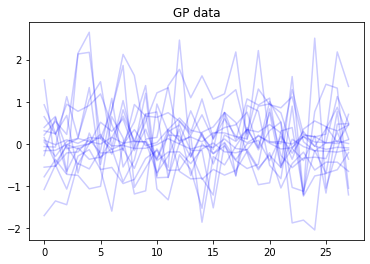

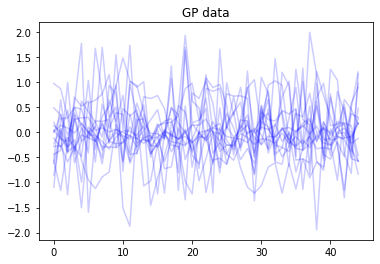

In [8]:
for batch in train_list[:2]:
  _, _, xt, yt = batch 
  for x, y in zip(xt, yt):
    plt.plot(y.cpu(), c='b', alpha=.2)
    plt.title(label='GP data')
    
  plt.show()

### Test Data

In [9]:
batch_size = 1
gptest = neural_processes.data_generator.GPCurves(batch_size, max_num_context, testing=True, dev='cuda')
test_list = [gptest.generate_curves() for _ in range(100)]

In [10]:
in_features = 1 
h_size = HIDDEN_SIZE
encoder_out = [128, 256, 512, 1024] # [h_size]*4
decoder_out = [512, 256] + [2] # [128]*2 + [2] 
mc_size = 1

In [11]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

### Output of predictive distribution without training

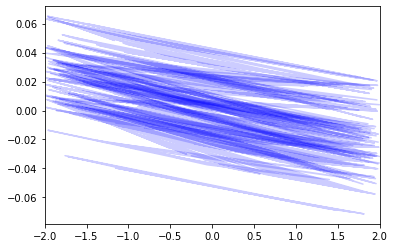

In [12]:
for i in range(50):
  xc, yc, xt, yt = train_list[i]
  z = torch.rand((16, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.xlim(-2, 2)

In [13]:
# Xavier_Uniform weight init
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

np.apply(init_weights)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

# Training

Iteration: 0, loss: 32.44057083129883


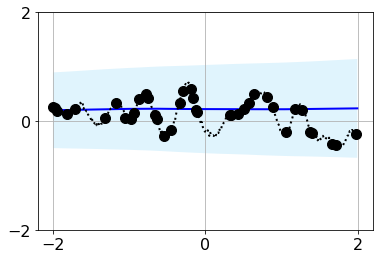

Iteration: 10000, loss: 7.53472900390625


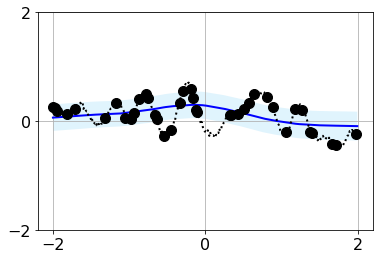

Iteration: 20000, loss: 5.9990410804748535


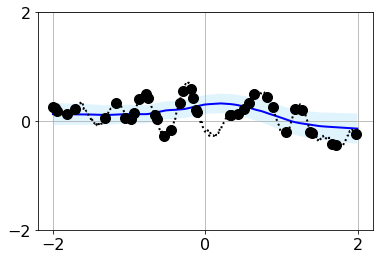

Iteration: 30000, loss: 4.470021724700928


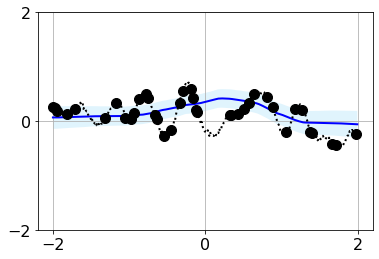

Iteration: 40000, loss: 1.0840654373168945


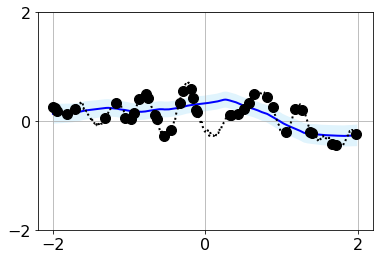

Iteration: 50000, loss: 47.874000549316406


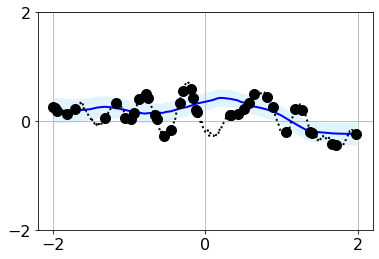

Iteration: 60000, loss: 12.441278457641602


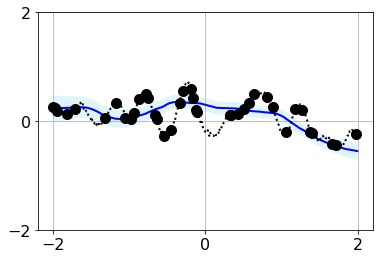

Iteration: 70000, loss: 4.305957317352295


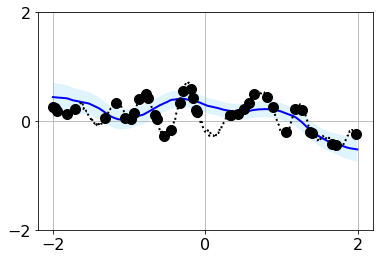

Iteration: 80000, loss: 0.02579951286315918


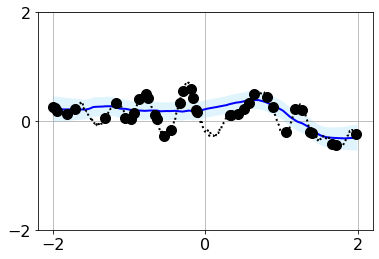

Iteration: 90000, loss: 2.3803229331970215


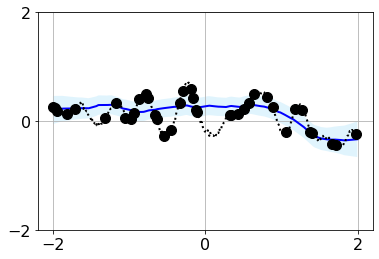

In [14]:
mu, sigma = np.fit(num_iter, save_iter, train_list, test_list)

### Save Neural Process model to Google Drive
Uncomment the code in the following cell to enable this.

In [15]:
# Mount drive
# Source: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
# from google.colab import drive
# drive.mount('/content/gdrive')

# Save model
# Source: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# !mkdir -p /content/gdrive/MyDrive/neural-processes-model
# torch.save(np, '/content/gdrive/MyDrive/neural-processes-model.pt')

In [16]:
# Hotfix for missing HTTP headers in pytorch's HTTP request for MNIST dataset download
# Source:
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### Output of predictive distribution after training given random latent Z (not related to stochastic process)


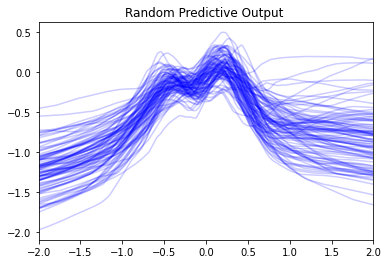

In [17]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  z = torch.rand((1, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Random Predictive Output ')
  plt.xlim(-2, 2)

### Output of predictive distribution after training given sampled latent Z

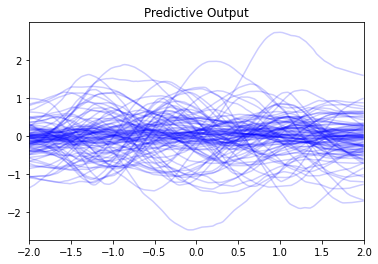

In [18]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  # z = torch.rand((1, h_size))
  # z = z[:, None, :].expand(-1, xt.shape[1], -1)
  (mu, sig, distr), q = np(xc, yc, xt)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Predictive Output')
  plt.xlim(-2, 2)

# Neural Processes for MNIST

In [19]:
# ToTensor() maps to range [0, 1]
train_mnist = datasets.MNIST('./data', download=True, transform=torchvision.transforms.ToTensor()) 
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Parameters

In [20]:
if dev.type == 'cuda':
  pin_memory = True
else:
  pin_memory = False

params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory': pin_memory}
          
train_generator = torch.utils.data.DataLoader(train_mnist, **params)

In [21]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 4,
          'pin_memory': pin_memory}
          
test_generator = torch.utils.data.DataLoader(test_mnist, **params)

In [22]:
in_features = 2 
h_size = 256
encoder_out = [h_size] # [128, 256, 512, 1024] 
decoder_out = [h_size] + [2] # [512, 256] + [2] 
mc_size = 1

## Create model

In [23]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=3, out_features=256, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=256, out_features=256, bias=True)
    (_log_sigma): Linear(in_features=256, out_features=256, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=258, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [24]:
# Define optimizer
opt = optim.Adam(np.parameters(), lr=5e-5) 

## Fit NP model to MNIST dataset



Epoch: 0, Iteration: 0, loss: 209.482666015625
Epoch: 0, Iteration: 1000, loss: 102.0611572265625
Epoch: 0, Iteration: 2000, loss: 39.413856506347656
Epoch: 0, Iteration: 3000, loss: 65.67192077636719
Iteration: 3749, loss: 66.32238006591797
136
783


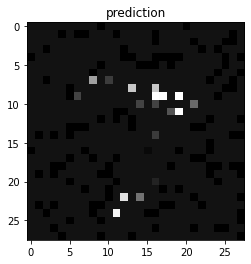

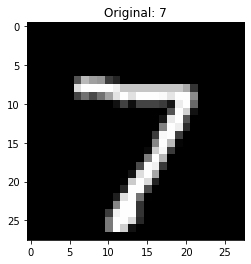

Epoch: 1, Iteration: 0, loss: 56.79995346069336
Epoch: 1, Iteration: 1000, loss: 97.02076721191406
Epoch: 1, Iteration: 2000, loss: 100.22901916503906
Epoch: 1, Iteration: 3000, loss: 76.45004272460938
Epoch: 2, Iteration: 0, loss: 88.48640441894531
Epoch: 2, Iteration: 1000, loss: 34.24140930175781
Epoch: 2, Iteration: 2000, loss: 81.60655212402344
Epoch: 2, Iteration: 3000, loss: 49.15998840332031
Epoch: 3, Iteration: 0, loss: 69.70785522460938
Epoch: 3, Iteration: 1000, loss: 60.342132568359375
Epoch: 3, Iteration: 2000, loss: 41.29552459716797
Epoch: 3, Iteration: 3000, loss: 18.270217895507812
Epoch: 4, Iteration: 0, loss: 75.55352783203125
Epoch: 4, Iteration: 1000, loss: 72.20613098144531
Epoch: 4, Iteration: 2000, loss: 65.34888458251953
Epoch: 4, Iteration: 3000, loss: 45.8492546081543
Epoch: 5, Iteration: 0, loss: 87.32698822021484
Epoch: 5, Iteration: 1000, loss: 49.683692932128906
Epoch: 5, Iteration: 2000, loss: 58.199195861816406
Epoch: 5, Iteration: 3000, loss: 70.780990

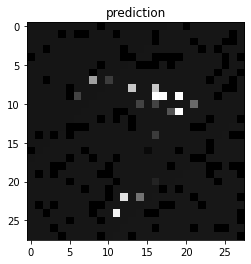

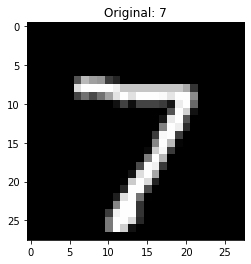

Epoch: 6, Iteration: 0, loss: 53.06674575805664
Epoch: 6, Iteration: 1000, loss: 105.7975845336914
Epoch: 6, Iteration: 2000, loss: 83.25005340576172
Epoch: 6, Iteration: 3000, loss: 91.90326690673828
Epoch: 7, Iteration: 0, loss: 96.66365051269531
Epoch: 7, Iteration: 1000, loss: 90.71502685546875
Epoch: 7, Iteration: 2000, loss: 60.705238342285156
Epoch: 7, Iteration: 3000, loss: 88.3250961303711
Epoch: 8, Iteration: 0, loss: 86.42549896240234
Epoch: 8, Iteration: 1000, loss: 41.33808898925781
Epoch: 8, Iteration: 2000, loss: 57.0151481628418
Epoch: 8, Iteration: 3000, loss: 114.35589599609375
Epoch: 9, Iteration: 0, loss: 91.83125305175781
Epoch: 9, Iteration: 1000, loss: 66.66574096679688
Epoch: 9, Iteration: 2000, loss: 87.00043487548828
Epoch: 9, Iteration: 3000, loss: 89.9660415649414
Epoch: 10, Iteration: 0, loss: 49.51585388183594
Epoch: 10, Iteration: 1000, loss: 46.28598403930664
Epoch: 10, Iteration: 2000, loss: 85.23795318603516
Epoch: 10, Iteration: 3000, loss: 18.4999771

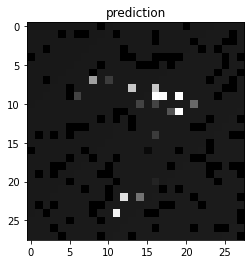

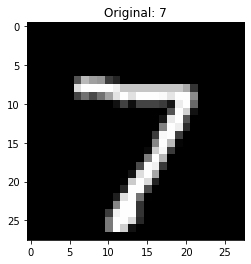

Epoch: 11, Iteration: 0, loss: 78.03733825683594
Epoch: 11, Iteration: 1000, loss: 52.42249298095703
Epoch: 11, Iteration: 2000, loss: 96.894775390625
Epoch: 11, Iteration: 3000, loss: 49.38275146484375
Epoch: 12, Iteration: 0, loss: 78.58429718017578
Epoch: 12, Iteration: 1000, loss: 76.88639068603516
Epoch: 12, Iteration: 2000, loss: 67.23944091796875
Epoch: 12, Iteration: 3000, loss: 68.2855453491211
Epoch: 13, Iteration: 0, loss: 74.51146697998047
Epoch: 13, Iteration: 1000, loss: 72.07843780517578
Epoch: 13, Iteration: 2000, loss: 90.04159545898438
Epoch: 13, Iteration: 3000, loss: 49.60291290283203
Epoch: 14, Iteration: 0, loss: 83.42476654052734
Epoch: 14, Iteration: 1000, loss: 61.548309326171875
Epoch: 14, Iteration: 2000, loss: 82.70991516113281
Epoch: 14, Iteration: 3000, loss: 66.11544799804688
Epoch: 15, Iteration: 0, loss: 101.44998168945312
Epoch: 15, Iteration: 1000, loss: 80.35272216796875
Epoch: 15, Iteration: 2000, loss: 65.52880859375
Epoch: 15, Iteration: 3000, los

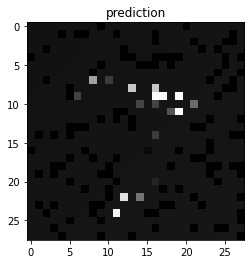

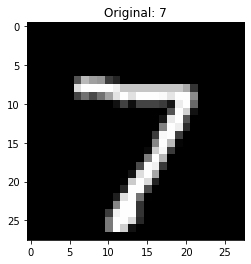

Epoch: 16, Iteration: 0, loss: 70.35258483886719
Epoch: 16, Iteration: 1000, loss: 63.646324157714844
Epoch: 16, Iteration: 2000, loss: 64.98934936523438
Epoch: 16, Iteration: 3000, loss: 57.86595153808594
Epoch: 17, Iteration: 0, loss: 99.57049560546875
Epoch: 17, Iteration: 1000, loss: 32.61090850830078
Epoch: 17, Iteration: 2000, loss: 47.38676834106445
Epoch: 17, Iteration: 3000, loss: 86.08648681640625
Epoch: 18, Iteration: 0, loss: 101.04495239257812
Epoch: 18, Iteration: 1000, loss: 97.79751586914062
Epoch: 18, Iteration: 2000, loss: 83.36861419677734
Epoch: 18, Iteration: 3000, loss: 35.48572540283203
Epoch: 19, Iteration: 0, loss: 80.8351821899414
Epoch: 19, Iteration: 1000, loss: 59.97256851196289
Epoch: 19, Iteration: 2000, loss: 61.69454574584961
Epoch: 19, Iteration: 3000, loss: 53.729042053222656
Epoch: 20, Iteration: 0, loss: 24.686824798583984
Epoch: 20, Iteration: 1000, loss: 57.35108184814453
Epoch: 20, Iteration: 2000, loss: 69.22178649902344
Epoch: 20, Iteration: 30

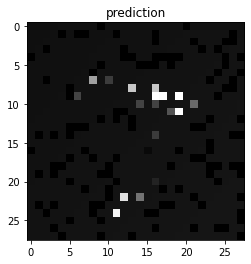

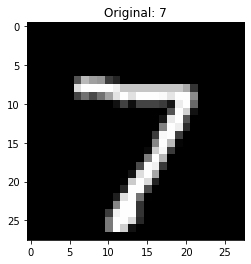

Epoch: 21, Iteration: 0, loss: 50.653228759765625
Epoch: 21, Iteration: 1000, loss: 38.86743927001953
Epoch: 21, Iteration: 2000, loss: 83.21202850341797
Epoch: 21, Iteration: 3000, loss: 36.572349548339844
Epoch: 22, Iteration: 0, loss: 72.30564880371094
Epoch: 22, Iteration: 1000, loss: 78.16486358642578
Epoch: 22, Iteration: 2000, loss: 79.93154907226562
Epoch: 22, Iteration: 3000, loss: 44.06237030029297
Epoch: 23, Iteration: 0, loss: 79.13668060302734
Epoch: 23, Iteration: 1000, loss: 75.18893432617188
Epoch: 23, Iteration: 2000, loss: 30.986034393310547
Epoch: 23, Iteration: 3000, loss: 91.27970886230469
Epoch: 24, Iteration: 0, loss: 58.53275680541992
Epoch: 24, Iteration: 1000, loss: 80.13623809814453
Epoch: 24, Iteration: 2000, loss: 44.925941467285156
Epoch: 24, Iteration: 3000, loss: 78.44550323486328
Epoch: 25, Iteration: 0, loss: 67.55859375
Epoch: 25, Iteration: 1000, loss: 73.67373657226562
Epoch: 25, Iteration: 2000, loss: 43.7639274597168
Epoch: 25, Iteration: 3000, lo

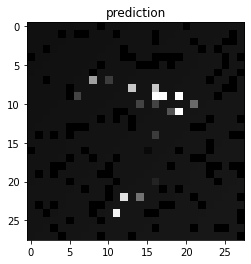

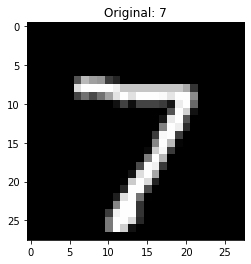

Epoch: 26, Iteration: 0, loss: 88.45199584960938
Epoch: 26, Iteration: 1000, loss: 95.068115234375
Epoch: 26, Iteration: 2000, loss: 65.51692199707031
Epoch: 26, Iteration: 3000, loss: 68.965576171875
Epoch: 27, Iteration: 0, loss: 33.4576301574707
Epoch: 27, Iteration: 1000, loss: 21.662109375
Epoch: 27, Iteration: 2000, loss: 78.15098571777344
Epoch: 27, Iteration: 3000, loss: 62.251502990722656
Epoch: 28, Iteration: 0, loss: 97.24585723876953
Epoch: 28, Iteration: 1000, loss: 42.443580627441406
Epoch: 28, Iteration: 2000, loss: 41.61675262451172
Epoch: 28, Iteration: 3000, loss: 57.22314453125
Epoch: 29, Iteration: 0, loss: 73.68656921386719
Epoch: 29, Iteration: 1000, loss: 75.6303482055664
Epoch: 29, Iteration: 2000, loss: 116.54643249511719
Epoch: 29, Iteration: 3000, loss: 41.65122604370117
Epoch: 30, Iteration: 0, loss: 87.5196533203125
Epoch: 30, Iteration: 1000, loss: 45.42329406738281
Epoch: 30, Iteration: 2000, loss: 88.08573913574219
Epoch: 30, Iteration: 3000, loss: 22.10

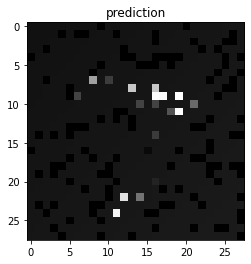

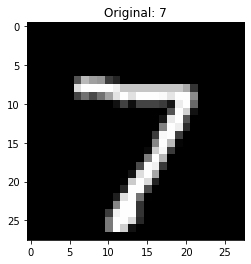

Epoch: 31, Iteration: 0, loss: 73.48461151123047
Epoch: 31, Iteration: 1000, loss: 82.33389282226562
Epoch: 31, Iteration: 2000, loss: 82.66173553466797
Epoch: 31, Iteration: 3000, loss: 61.29120635986328
Epoch: 32, Iteration: 0, loss: 24.025941848754883
Epoch: 32, Iteration: 1000, loss: 48.43364715576172
Epoch: 32, Iteration: 2000, loss: 52.61366271972656
Epoch: 32, Iteration: 3000, loss: 54.67214584350586
Epoch: 33, Iteration: 0, loss: 44.84086608886719
Epoch: 33, Iteration: 1000, loss: 35.47514724731445
Epoch: 33, Iteration: 2000, loss: 72.80650329589844
Epoch: 33, Iteration: 3000, loss: 93.33168029785156
Epoch: 34, Iteration: 0, loss: 68.85525512695312
Epoch: 34, Iteration: 1000, loss: 82.39126586914062
Epoch: 34, Iteration: 2000, loss: 40.724822998046875
Epoch: 34, Iteration: 3000, loss: 51.52874755859375
Epoch: 35, Iteration: 0, loss: 75.11886596679688
Epoch: 35, Iteration: 1000, loss: 66.21304321289062
Epoch: 35, Iteration: 2000, loss: 49.12327575683594
Epoch: 35, Iteration: 300

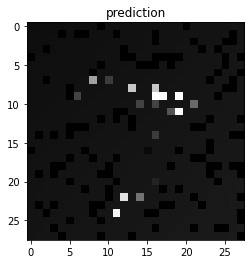

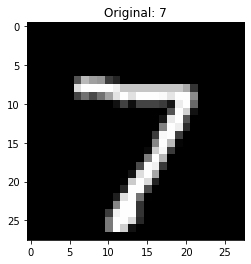

Epoch: 36, Iteration: 0, loss: 67.22947692871094
Epoch: 36, Iteration: 1000, loss: 83.74588775634766
Epoch: 36, Iteration: 2000, loss: 45.570030212402344
Epoch: 36, Iteration: 3000, loss: 48.68051528930664
Epoch: 37, Iteration: 0, loss: 75.9760513305664
Epoch: 37, Iteration: 1000, loss: 35.51502990722656
Epoch: 37, Iteration: 2000, loss: 71.09410095214844
Epoch: 37, Iteration: 3000, loss: 69.4931640625
Epoch: 38, Iteration: 0, loss: 21.459842681884766
Epoch: 38, Iteration: 1000, loss: 61.326148986816406
Epoch: 38, Iteration: 2000, loss: 35.94689178466797
Epoch: 38, Iteration: 3000, loss: 74.64451599121094
Epoch: 39, Iteration: 0, loss: 71.86719512939453
Epoch: 39, Iteration: 1000, loss: 46.37456512451172
Epoch: 39, Iteration: 2000, loss: 62.15285873413086
Epoch: 39, Iteration: 3000, loss: 24.970518112182617
Epoch: 40, Iteration: 0, loss: 67.205810546875
Epoch: 40, Iteration: 1000, loss: 54.770294189453125
Epoch: 40, Iteration: 2000, loss: 57.388671875
Epoch: 40, Iteration: 3000, loss: 

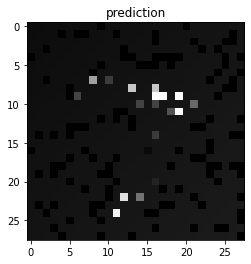

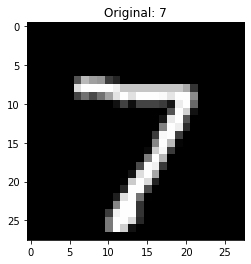

Epoch: 41, Iteration: 0, loss: 66.9692153930664
Epoch: 41, Iteration: 1000, loss: 69.05416107177734
Epoch: 41, Iteration: 2000, loss: 89.76925659179688
Epoch: 41, Iteration: 3000, loss: 50.87638854980469
Epoch: 42, Iteration: 0, loss: 44.07990264892578
Epoch: 42, Iteration: 1000, loss: 26.108543395996094
Epoch: 42, Iteration: 2000, loss: 45.84539031982422
Epoch: 42, Iteration: 3000, loss: 96.71086120605469
Epoch: 43, Iteration: 0, loss: 87.97355651855469
Epoch: 43, Iteration: 1000, loss: 15.358562469482422
Epoch: 43, Iteration: 2000, loss: 86.44125366210938
Epoch: 43, Iteration: 3000, loss: 43.655120849609375
Epoch: 44, Iteration: 0, loss: 44.855464935302734
Epoch: 44, Iteration: 1000, loss: 47.29122543334961
Epoch: 44, Iteration: 2000, loss: 36.221351623535156
Epoch: 44, Iteration: 3000, loss: 85.62110900878906
Epoch: 45, Iteration: 0, loss: 26.955917358398438
Epoch: 45, Iteration: 1000, loss: 61.8127555847168
Epoch: 45, Iteration: 2000, loss: 100.8661117553711
Epoch: 45, Iteration: 3

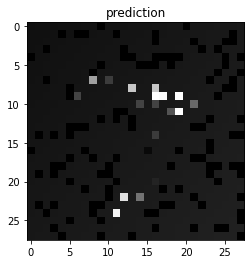

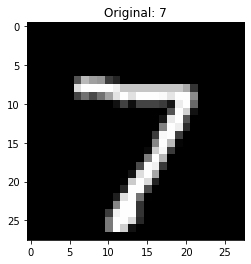

Epoch: 46, Iteration: 0, loss: 94.24742126464844
Epoch: 46, Iteration: 1000, loss: 82.38325500488281
Epoch: 46, Iteration: 2000, loss: 76.06475830078125
Epoch: 46, Iteration: 3000, loss: 41.34801483154297
Epoch: 47, Iteration: 0, loss: 71.365966796875
Epoch: 47, Iteration: 1000, loss: 48.98014831542969
Epoch: 47, Iteration: 2000, loss: 92.81138610839844
Epoch: 47, Iteration: 3000, loss: 28.47158432006836
Epoch: 48, Iteration: 0, loss: 65.14669799804688
Epoch: 48, Iteration: 1000, loss: 30.51851463317871
Epoch: 48, Iteration: 2000, loss: 79.92190551757812
Epoch: 48, Iteration: 3000, loss: 60.304786682128906
Epoch: 49, Iteration: 0, loss: 45.195064544677734
Epoch: 49, Iteration: 1000, loss: 42.61034393310547
Epoch: 49, Iteration: 2000, loss: 52.28654479980469
Epoch: 49, Iteration: 3000, loss: 101.17311096191406


In [25]:
epochs = 50
save_epoch = 5
num_iter = 60000 // 16
# mu, sigma = fit_mnist(epochs, num_iter, save_epoch, np, opt, train_generator, test_generator, dev)
mu, sigma = neural_processes.mnist.fit_mnist2(epochs, 
                                              save_epoch,
                                              np, opt, 
                                              train_generator, 
                                              test_generator, 
                                              dev)

In [26]:
# TODO overfitting 3 classes, avg. epoch loss

In [27]:
test_set = neural_processes.mnist.preprocess_mnist(test_generator, dev, train=False)

In [28]:
xc, yc, xt, yt = test_set[6]

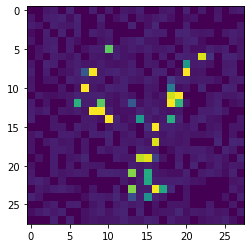

In [32]:
m = torch.zeros(28, 28)
x, y = neural_processes.plot.rescale(xt[0], mu.detach()[0], 'cpu')
xk, yk = neural_processes.plot.rescale(xc[0], yc[0], 'cpu')

num_context = xk.shape[0]

for i, val in enumerate(x):
    
    if i < num_context:
      m[val[0], val[1]] = yk[i]
    else:
      m[val[0], val[1]] = y[i]

plt.imshow(m)